In [3]:
import pandas as pd 
import os 
import numpy as np 
import matplotlib.pyplot as plt
import upsetplot
from upsetplot import from_contents
from upsetplot import UpSet
import glob
import collections
import seaborn as sns
import matplotlib.ticker as ticker
import tarfile


In [4]:
path_data = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/v2_v2.5f0752a_conf2_annotFrame_cap0_runs_pya0.17.1/TCGA_Breast_1102/filter_{}.all/commit_6e25db6_{}'.format(sample, background)

NameError: name 'sample' is not defined

In [5]:
#all_paths = glob.glob(path_data + '/G_*tsv')

In [6]:
#all_paths = [path for path in all_paths if 'Uniprot' in path ]

In [7]:
#len(np.unique(all_paths))

In [8]:
plot_dir = '/cluster/work/grlab/projects/projects2020_OHSU/plots'
plot_dir = os.path.join(plot_dir, 'upset_plots')
os.mkdir(plot_dir)


FileExistsError: [Errno 17] File exists: '/cluster/work/grlab/projects/projects2020_OHSU/plots/upset_plots'

# Helpers



In [9]:
def ohsu_to_eth(path):
    cohort = {'NormalCohortcore_GTEx_': 'Gtexcore', 
             'NormalCohortpaired_': 'Matched', 
             'NormalCohortAll_':'Alls'}
    
    key_to_apply = [k for k in cohort if k in path]
    if key_to_apply: 
        key_to_apply = key_to_apply[0]
        path = path.replace(key_to_apply, '')
        path = path.replace('FiltNormalsC','FiltNormals{}C'.format(cohort[key_to_apply]) )

        path = path.replace('J_', 'G_')

        path = path.replace('CohortLim', '.0CohortLim')
        sample = path.split('_')[1]
        #print(path)
        return path, sample
    else:
        return None, None 

In [10]:
def get_eth_path(base_folder_ETH, name_eth=None, sample=None):
    path_o = None 
    if name_eth is not None: 
        path_list = os.path.join(base_folder_ETH, 'filter_' + sample, '*', name_eth, 'part*')
        path_list = glob.glob(path_list)
        if path_list:
            path_o = path_list[0]
    return path_o 
    

In [11]:
def get_file_pairs(tar_file_OHSU, base_folder_ETH):
    file_pair = {'eth':[], 'ohsu': []}
    with tarfile.open(tar_file_OHSU, "r:*") as tar:
        file_names_OHSU = tar.getnames()

        for name_ohsu in file_names_OHSU:
            name_eth, sample = ohsu_to_eth(name_ohsu)
            eth_path = get_eth_path(base_folder_ETH, name_eth, sample)
            if (eth_path is not None) and os.path.isfile(eth_path):
                file_pair['eth'].append(eth_path) 
                file_pair['ohsu'].append(name_ohsu)
    return file_pair

# Main Data

In [12]:
tar_file_OHSU = '/cluster/work/grlab/projects/projects2020_OHSU/share_OHUS_PNLL/Aug21_graph_data_current/OHSU_kmer_lists_Nov24.tar.gz'
base_folder_ETH = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/v2_v2.5f0752a_conf2_annotFrame_cap0_runs_pya0.17.1/TCGA_Breast_1102'


In [13]:
file_pair = get_file_pairs(tar_file_OHSU, base_folder_ETH)

In [14]:
sample = 'TCGA-AO-A0JM-01A-21R-A056-07'
background = 'core'

valid_idx = [idx for  idx, eth in enumerate(file_pair['eth'])  if (sample in eth) and (background in eth)]
len(valid_idx)

48

In [15]:
simple_content = {}
with tarfile.open(tar_file_OHSU, "r:*") as tar:
    for idx in valid_idx:
        #print('processing {}'.format(idx))
        df_eth = pd.read_csv(file_pair['eth'][idx], sep="\t", usecols = ['kmer'])['kmer'].tolist()
        df_ohsu = pd.read_csv(tar.extractfile(file_pair['ohsu'][idx]), sep="\t", usecols = ['kmer'])['kmer'].tolist()
        label_eth = file_pair['eth'][idx].split('/')[-2]
        label_ohsu = file_pair['ohsu'][idx]
        
        simple_content[label_ohsu] = np.unique(df_ohsu)
        simple_content[label_eth] = np.unique(df_eth)

print('done')

done


# Upset Plot

In [92]:
def plot_subsets(myplot_collect, coloring_set=None, 
                 sort_by='degree', 
                 show_counts=None, show_percentages=False, 
                 min_subset_size=None, max_subset_size=None, 
                 min_degree=None, save_path=None, save=False):

    myplot = from_contents(myplot_collect)

    plt.figure(figsize=(10,25))
    upset = UpSet(myplot, intersection_plot_elements=50, sort_by=sort_by, show_counts=show_counts, 
                             show_percentages=show_percentages,
                             min_subset_size=min_subset_size, 
                             max_subset_size=max_subset_size, min_degree=min_degree)
    legend_label = "Intersections involving both Graph and Junction Pipelines"
    if coloring_set:
        upset.style_subsets(present=coloring_set, facecolor="blue", label=legend_label)
    params = {'legend.fontsize': 50}
    with plt.rc_context(params):
        plotted = upset.plot()
    
    plotted['intersections'].set_yticklabels(plotted['intersections'].get_yticks(), fontsize=30)
    plotted['intersections'].set_ylabel(plotted['intersections'].get_ylabel(), fontsize=30)

    if save:
        print("save to {}".format(save_path))
        plt.savefig(save_path, bbox_inches='tight', dpi = 300)
    plt.show()
    return plotted


In [17]:
def get_tag(coloring, max_subset_size, min_subset_size, min_degree, show_percentages, show_counts, sort_by):
    base_tag = ''
    if coloring: 
        base_tag += 'blue_'
    if max_subset_size:
        base_tag += 'mxinter{}_'.format(max_subset_size)
    if min_subset_size:
        base_tag += 'mninter{}_'.format(min_subset_size)
    if min_degree:
        base_tag += 'mndegree{}_'.format(min_degree)
    if show_percentages:
        base_tag += 'w%_'
    if show_counts:
        base_tag += 'wCts_'
    if sort_by == 'degree':
        base_tag += 'sortD'
    elif sort_by == 'cardinality':
         base_tag += 'sortC'
    return base_tag

/cluster/work/grlab/projects/projects2020_OHSU/plots/upset_plots/v2_v2.5f0752a_conf2_BRCA_TCGA-AO-A0JM-01A-21R-A056-07_core_Upsetblue_mxinter500_mndegree7_wCts_sortC_Gr_Jn.png


<ipython-input-92-6c665407eafd>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plotted['intersections'].set_yticklabels(plotted['intersections'].get_yticks(), fontsize=30)


<Figure size 720x1800 with 0 Axes>

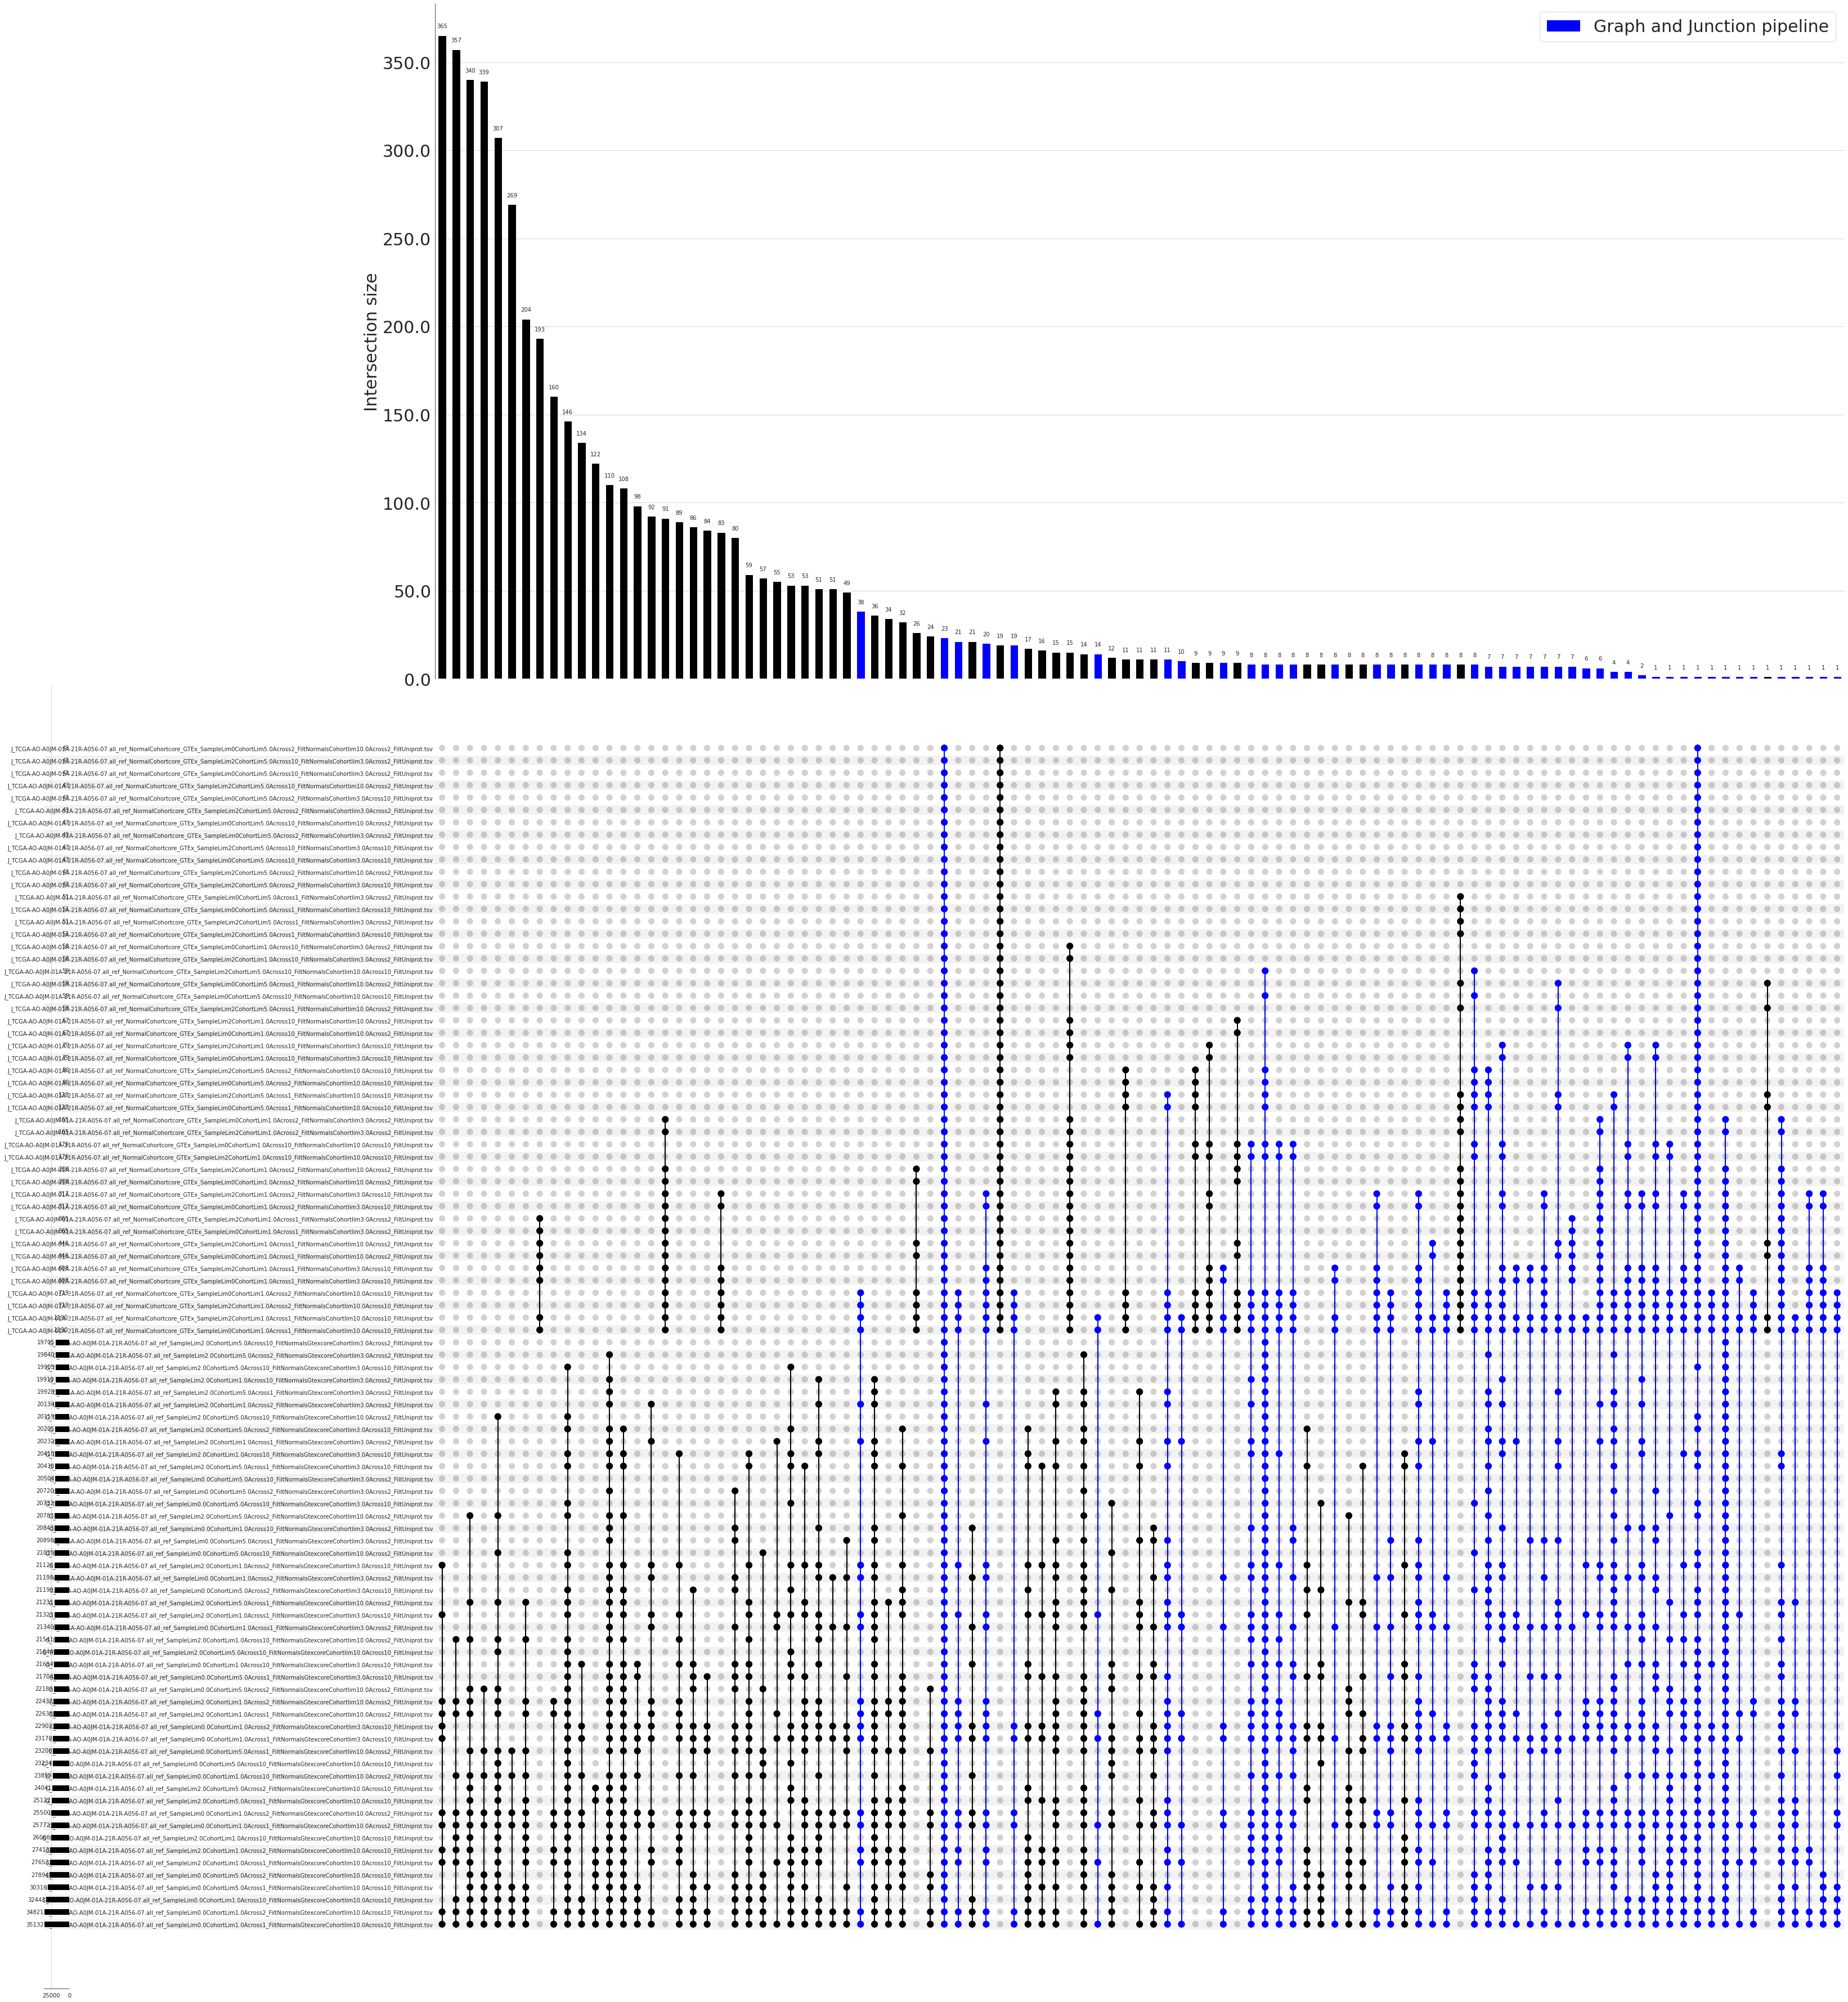

In [93]:
max_subset_size = 500
min_degree = 7
show_percentages=False
show_counts='%d'
sort_by='cardinality' #degree
colors_ = True
min_subset_size = None
if colors_: 
    lenients = ['J_TCGA-AO-A0JM-01A-21R-A056-07.all_ref_NormalCohortcore_GTEx_SampleLim0CohortLim1.0Across1_FiltNormalsCohortlim10.0Across10_FiltUniprot.tsv', 
               'G_TCGA-AO-A0JM-01A-21R-A056-07.all_ref_SampleLim0.0CohortLim1.0Across1_FiltNormalsGtexcoreCohortlim10.0Across10_FiltUniprot.tsv']

#     lenients = ['J_TCGA-AO-A0JM-01A-21R-A056-07.all_ref_NormalCohortpaired_SampleLim0CohortLim1.0Across1_FiltNormalsCohortlim10.0Across10_FiltUniprot.tsv', 
#     'G_TCGA-AO-A0JM-01A-21R-A056-07.all_ref_SampleLim0.0CohortLim1.0Across1_FiltNormalsMatchedCohortlim10.0Across10_FiltUniprot.tsv']
else:
    lenients = None 

tag = get_tag(colors_, max_subset_size, min_subset_size, min_degree, show_percentages, show_counts, sort_by)
base_plot = 'v2_v2.5f0752a_conf2_BRCA_{}_{}'.format(sample, background)
name_plot = base_plot + '_Upset{}_Gr_Jn.png'.format(tag)
save_path = os.path.join(plot_dir, name_plot)
print(save_path)

save = False
myplot = plot_subsets(simple_content, coloring_set=lenients, sort_by=sort_by, 
                      show_counts=show_counts, show_percentages=show_percentages,
                      min_subset_size=min_subset_size, max_subset_size=max_subset_size, min_degree=min_degree,
                      save_path=save_path, save=save)

# Other Plots

In [32]:
myplot

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

In [81]:
myplot['intersections'].legend(["blue"], prop={"size":20})




In [69]:

myplot['intersections'].get_


<bound method _AxesBase.get_legend of <AxesSubplot:ylabel='Intersection size'>>

In [28]:
myplot['shading'].set_yticklabels(myplot['shading'].get_yticklabels())


[]

/cluster/work/grlab/projects/projects2020_OHSU/plots/upset_plots/v2_v2.5f0752a_conf2_BRCA_TCGA-AO-A0JM-01A-21R-A056-07_matchedNormals_Upset_G_J.png
save to /cluster/work/grlab/projects/projects2020_OHSU/plots/upset_plots/v2_v2.5f0752a_conf2_BRCA_TCGA-AO-A0JM-01A-21R-A056-07_matchedNormals_Upset_G_J.png


<Figure size 720x1800 with 0 Axes>

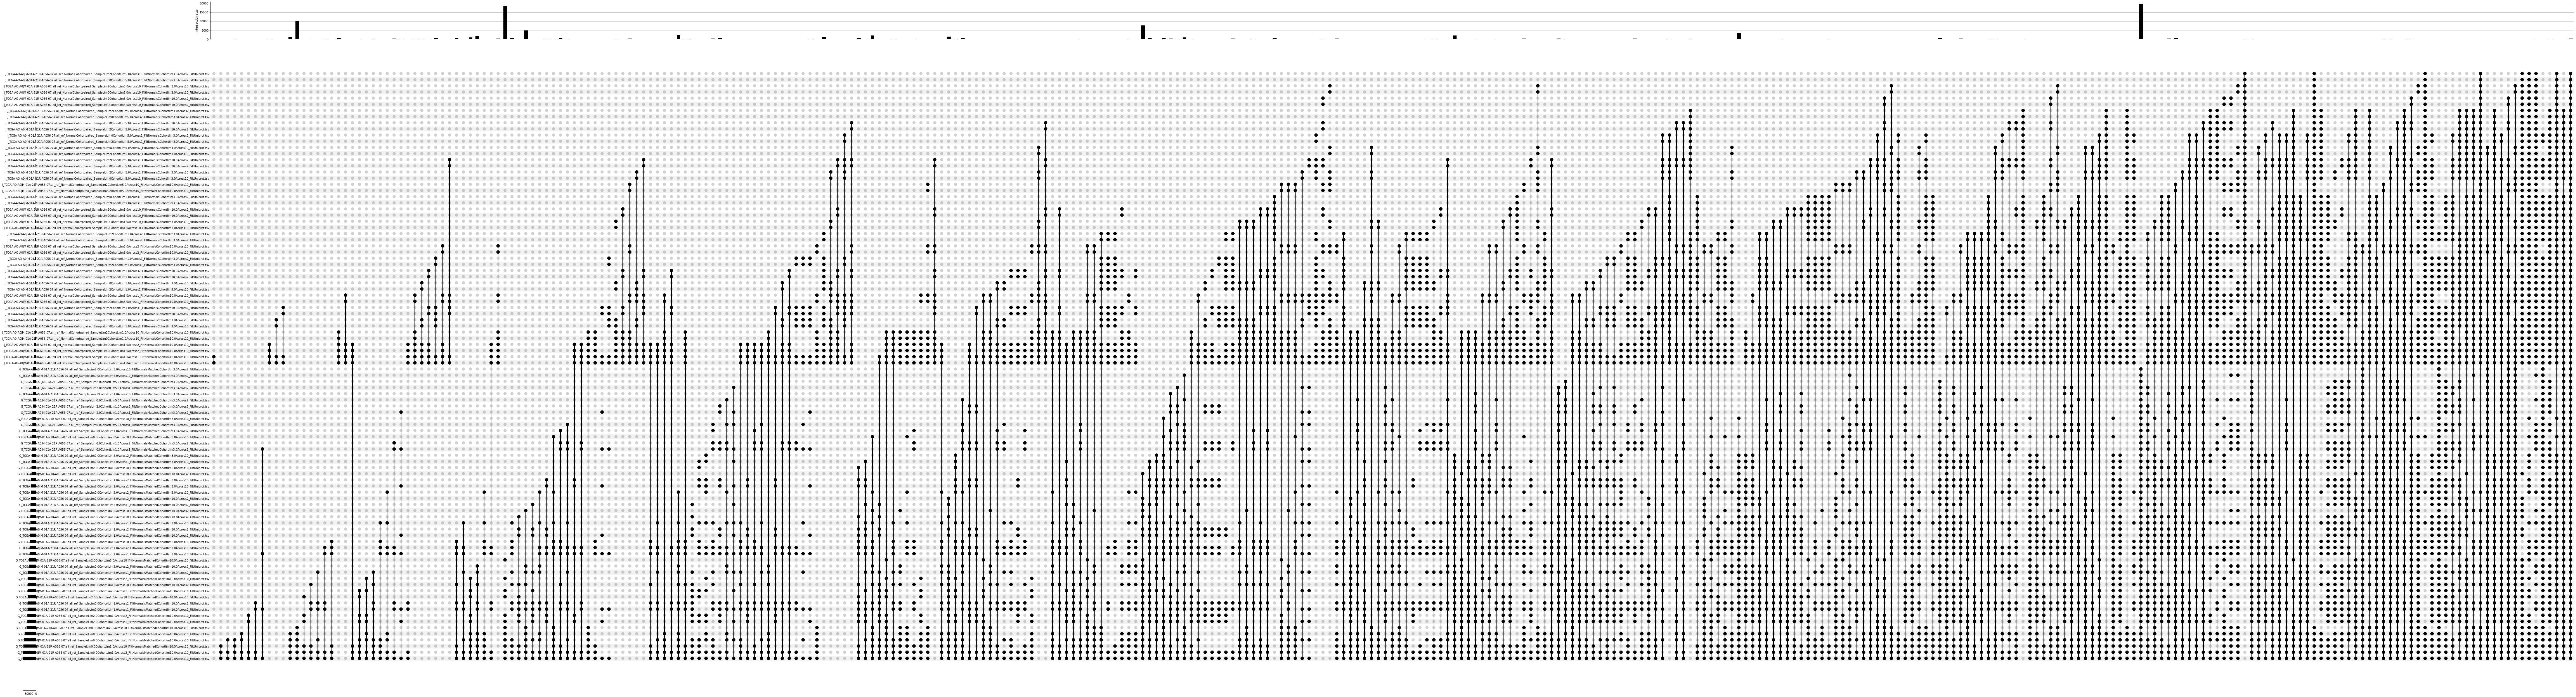

In [29]:
base_plot = 'v2_v2.5f0752a_conf2_BRCA_{}_{}'.format(sample, background)
save_path = os.path.join(plot_dir, base_plot + '_Upset' + '_G_J'+ '.png')
print(save_path)

save = True
myplot = plot_subsets(simple_content, save_path=save_path, save=save)

/cluster/work/grlab/projects/projects2020_OHSU/plots/upset_plots/v2_v2.5f0752a_conf2_BRCA_TCGA-AO-A0JM-01A-21R-A056-07_core_Upset_G_J.png
save to /cluster/work/grlab/projects/projects2020_OHSU/plots/upset_plots/v2_v2.5f0752a_conf2_BRCA_TCGA-AO-A0JM-01A-21R-A056-07_core_Upset_G_J.png


<Figure size 720x1800 with 0 Axes>

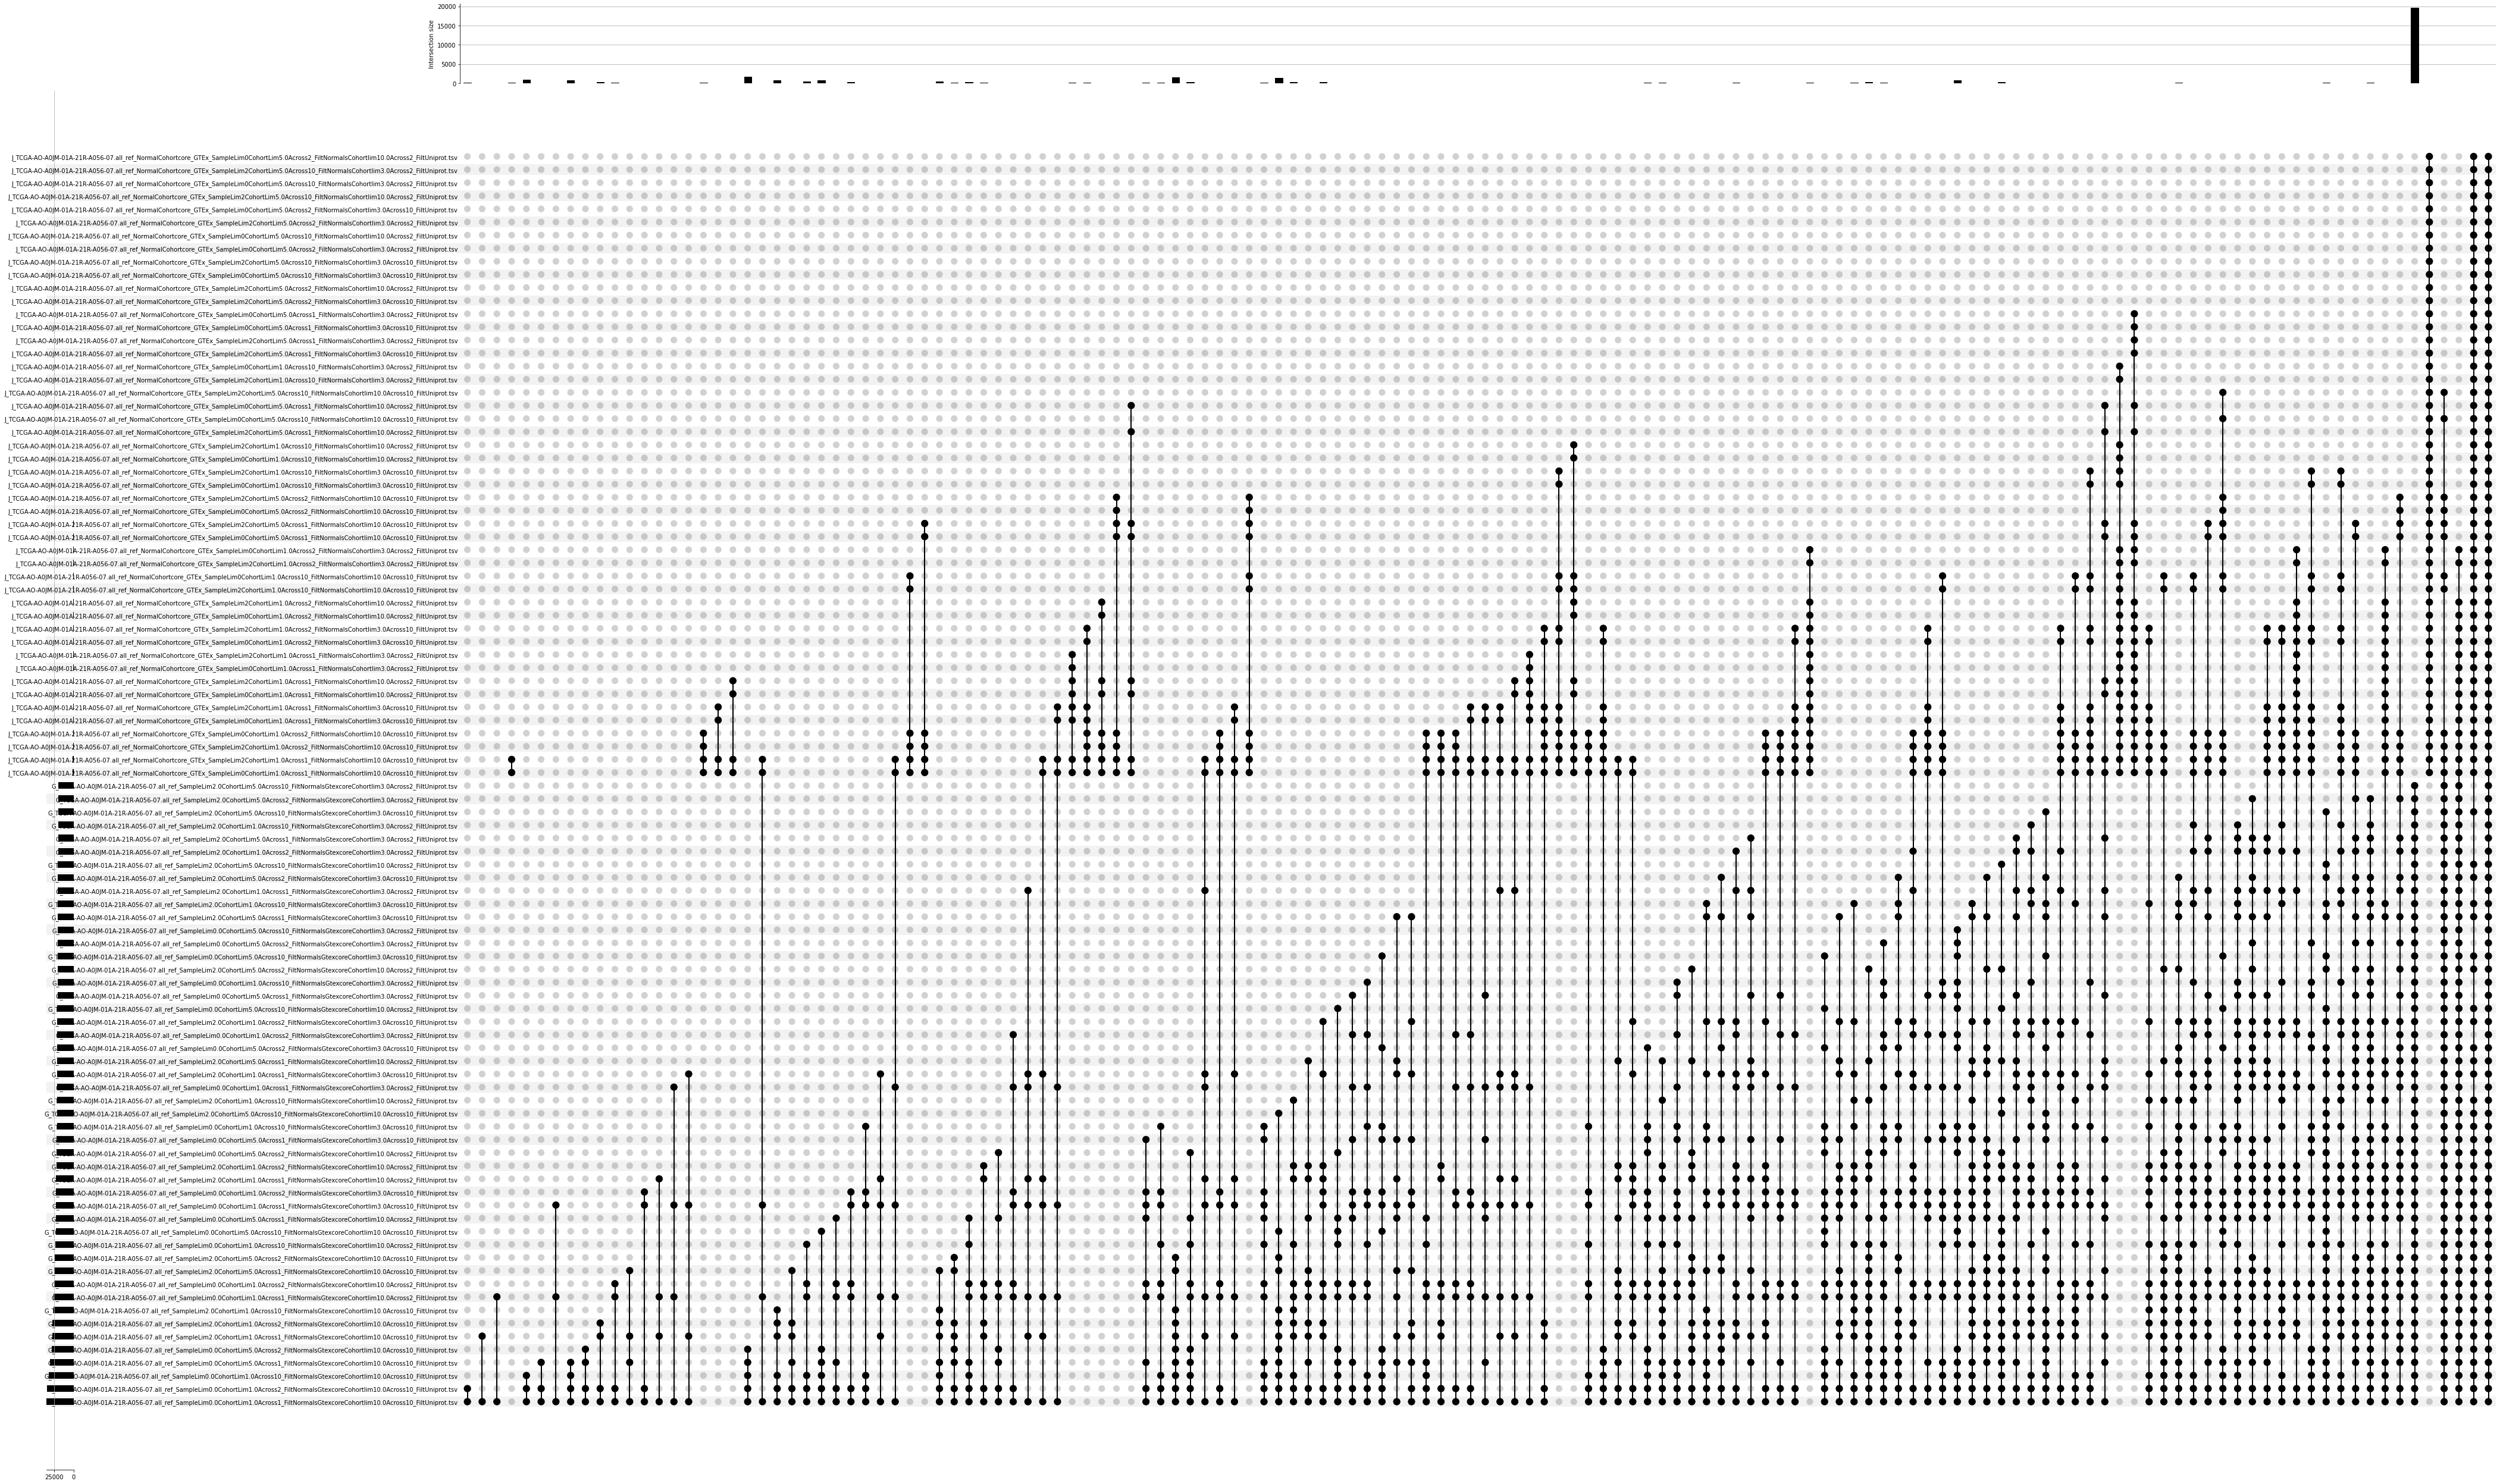

In [25]:
base_plot = 'v2_v2.5f0752a_conf2_BRCA_{}_{}'.format(sample, background)
save_path = os.path.join(plot_dir, base_plot + '_Upset' + '_G_J'+ '.png')

print(save_path)

save = True
myplot = plot_subsets(simple_content, save_path=save_path, save=save)

/cluster/work/grlab/projects/projects2020_OHSU/plots/upset_plots/v2_v2.5f0752a_conf2_BRCA_TCGA-AO-A0JM-01A-21R-A056-07_matchedNormals_Upset_lim500_G_J.png
save to /cluster/work/grlab/projects/projects2020_OHSU/plots/upset_plots/v2_v2.5f0752a_conf2_BRCA_TCGA-AO-A0JM-01A-21R-A056-07_matchedNormals_Upset_lim500_G_J.png


<Figure size 720x1800 with 0 Axes>

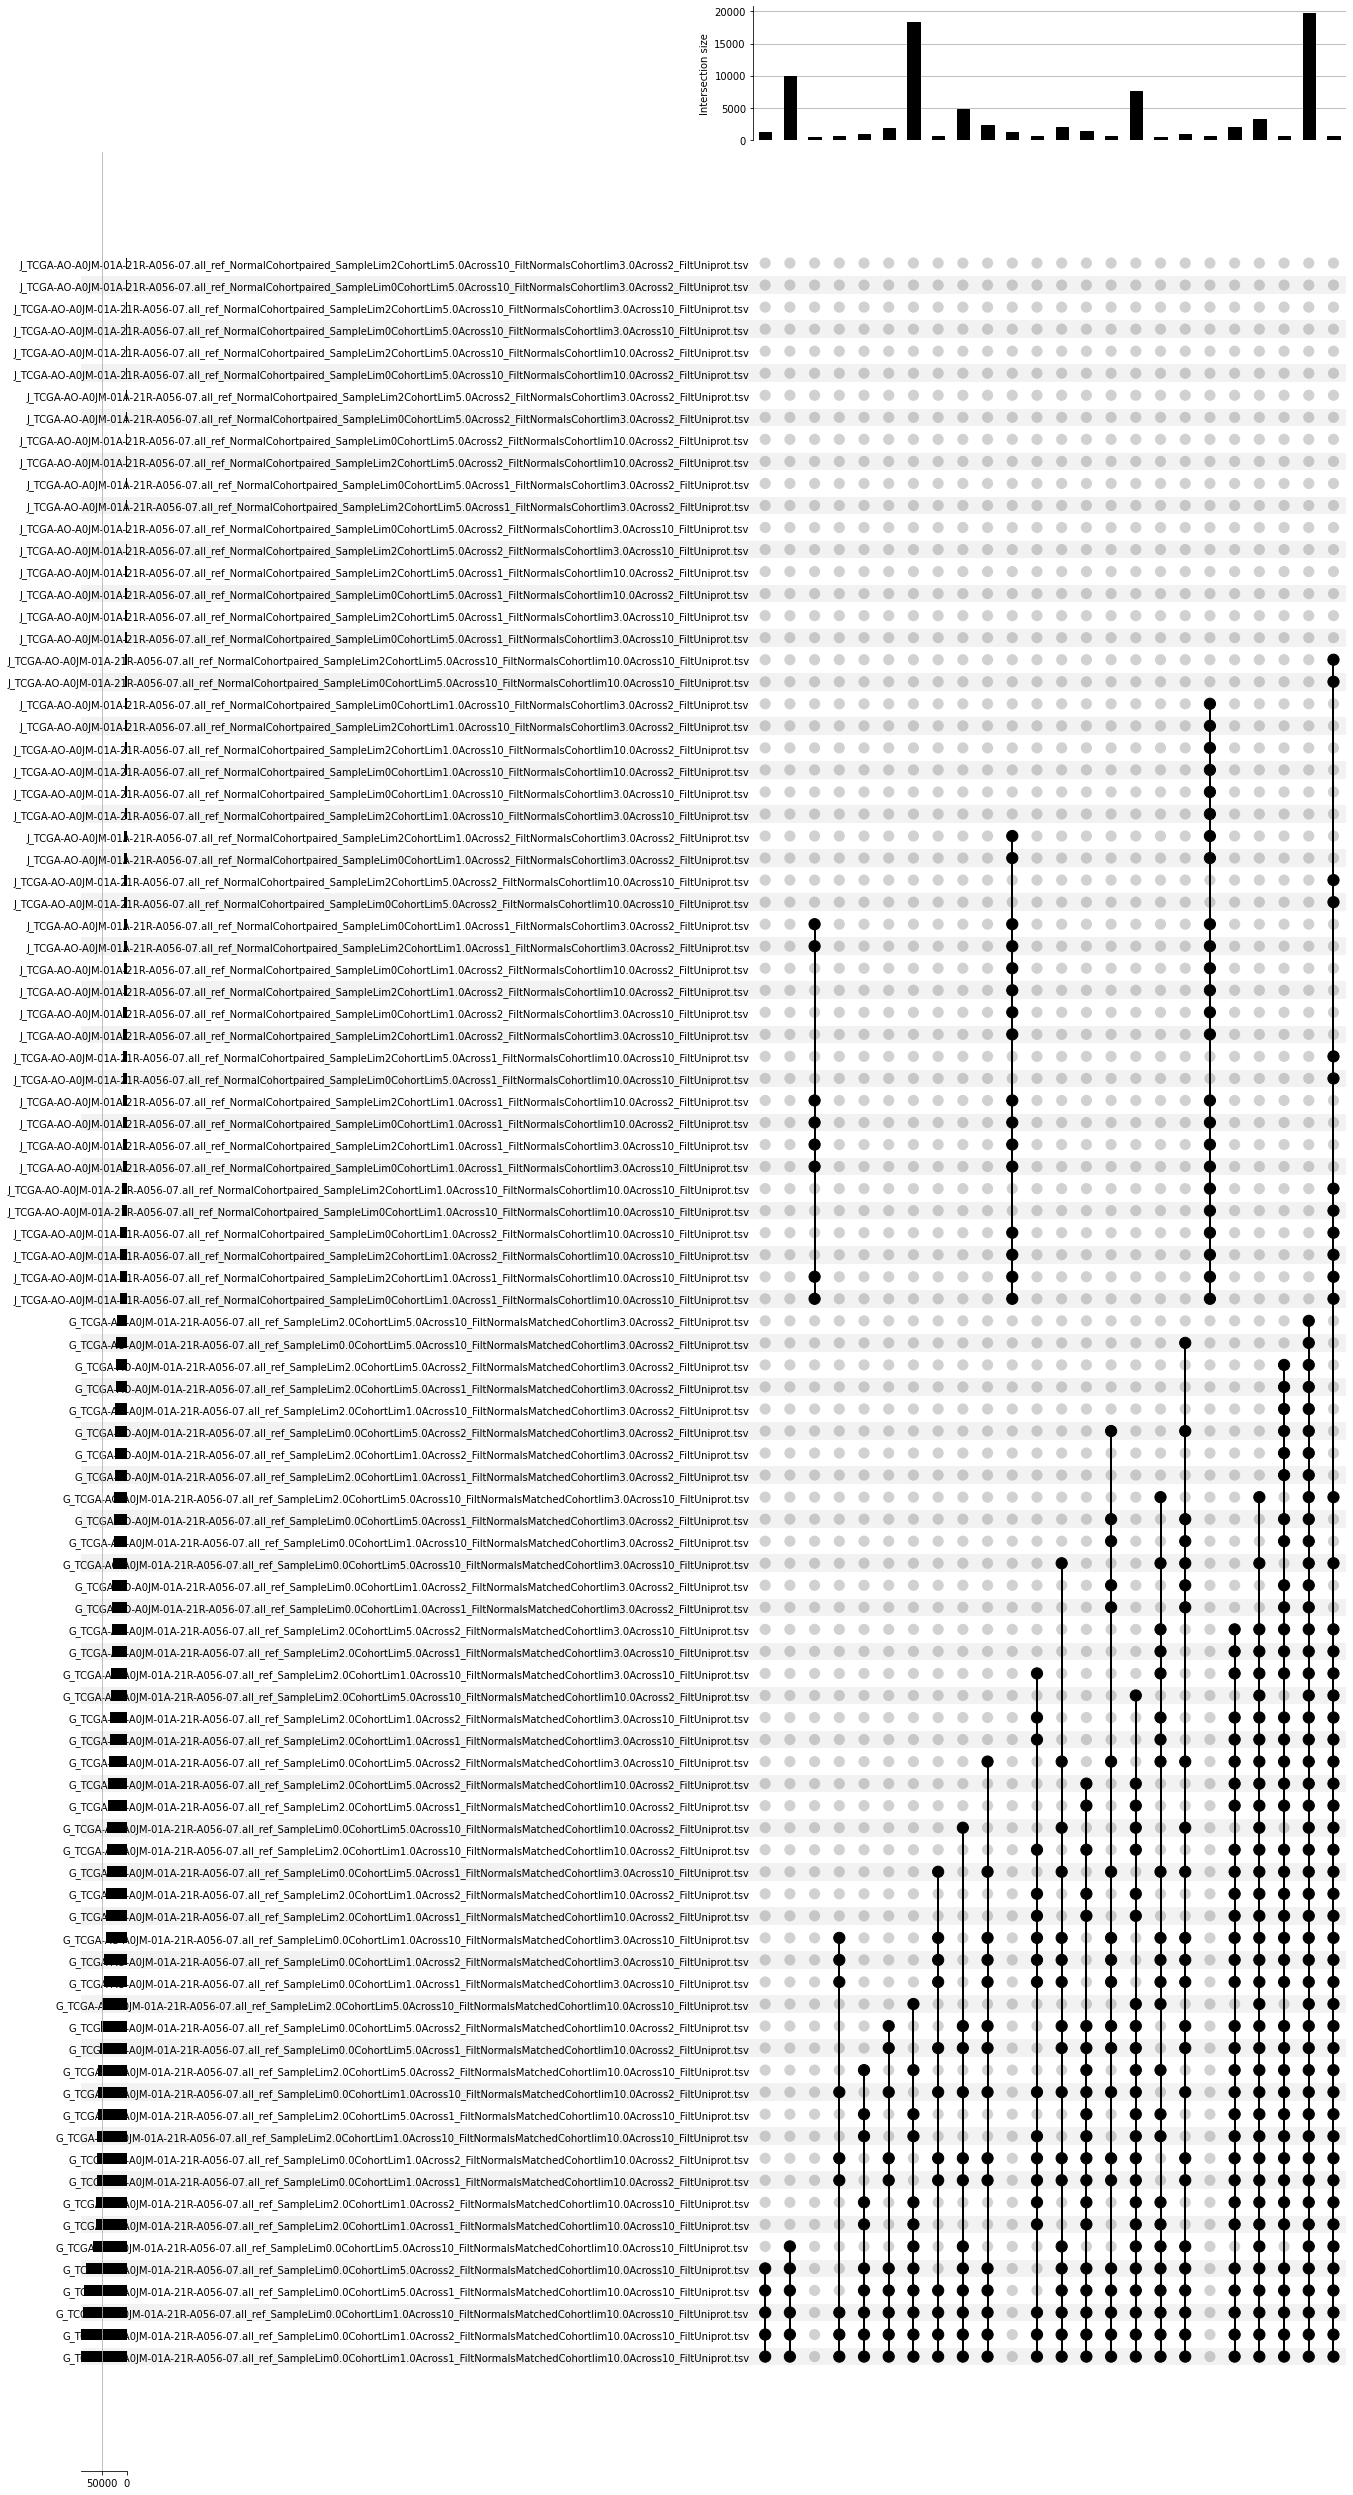

In [32]:
min_subset_size = 500
base_plot = 'v2_v2.5f0752a_conf2_BRCA_{}_{}'.format(sample, background)
save_path = os.path.join(plot_dir, base_plot + '_Upset_lim' + str(min_subset_size) + '_G_J'+ '.png')
print(save_path)

save = False
myplot = plot_subsets(simple_content, min_subset_size=min_subset_size, save_path=save_path, save=save)

# Legend


In [49]:
def path_to_condition(all_paths):
    # None handling added 
    
    all_paths = [path.replace('None', '0') for path in all_paths]
    sample_expr = [np.float(os.path.basename(path).split('ref_SampleLim')[1].split('Cohort')[0]) 
                   for path in all_paths ]

    foreground_cohort_expr = [np.float(os.path.basename(path).split('CohortLim')[1].split('Across')[0])
                                       for path in all_paths ]

    foreground_cohort_samples = [np.int(os.path.basename(path).split('Across')[1].split('_Filt')[0] ) 
                                 for path in all_paths ]

    background_cohort_expr = [np.float(os.path.basename(path).split('Cohortlim')[1].split('Across')[0])
                              for path in all_paths ]

    background_cohort_samples = [np.int(os.path.basename(path).split('Across')[2].split('_FiltUn')[0])
                                 for path in all_paths ]
    background_cohort_id = [os.path.basename(path).split('Normals')[1].split('lim')[0] for path in all_paths ]

    legend_quant = pd.DataFrame({'sample_expr':sample_expr, 
                  'foreground_cohort_expr': foreground_cohort_expr, 
                  'foreground_cohort_samples': foreground_cohort_samples, 
                  'background_cohort_expr': background_cohort_expr,
                  'background_cohort_samples' : background_cohort_samples, 
                    'background_cohort_id':background_cohort_id})


    sort_legend = False
    if sort_legend:
        legend_quant = legend_quant.sort_values("background_cohort_samples", ascending=False).\
        sort_values("background_cohort_expr", ascending=False).\
        sort_values("foreground_cohort_samples", ascending=False).\
        sort_values("foreground_cohort_expr", ascending=False).\
        sort_values("sample_expr", ascending=False)
    return legend_quant

In [50]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)


# y = legend_quant["background_cohort_samples"]
# x = legend_quant["index"]
# sns.barplot(y, x, palette=colors_from_values(y, "YlOrRd"), orient="h")

In [51]:
def plot_legend(y1, y2, y3, y4, y5, y6, x, save_path=None, save=False):
    #sns.set(style="white", context="talk")  
    sns.set_style("white")
    #, {
    #     "ytick.major.size": 0.1,
    #     "ytick.minor.size": 0.05,
    #     'grid.linestyle': '--', 
    #         "xtick.major.size": 0.1,
    #     "xtick.minor.size": 0.05,
    #     'grid.linestyle': '--'
    #  })
    rs = np.random.RandomState(8)  
    min_axes = -0.5
    y_label_size = 12
    x_label_size = 20
    # Set up the matplotlib figure  
    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(8,10), sharey=True)  


    sns.barplot(x=y1, y=x, palette=colors_from_values(y1, "YlOrRd"), ax=ax1, orient="h")  
    #ax1.axhline(0, color="k", clip_on=True)  
    #ax1.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax1.set_xlim([min_axes, max(y1)])
    #ax1.set_ylabel(y1.name, fontsize=y_label_size) 
    ax1.tick_params(labelsize=x_label_size) 


    sns.barplot(x=y2, y=x, palette=colors_from_values(y2, "vlag"), ax=ax2, orient="h", linewidth=1)  
    #ax2.axhline(0, color="k", clip_on=False)  
    ax2.set_xlim([min_axes, max(y2)])
    #ax2.set_ylabel(y2.name, fontsize=y_label_size) 
    ax2.tick_params(labelsize=x_label_size) 

    sns.barplot(x=y3, y=x, palette=colors_from_values(y3, "deep"), ax=ax3, orient="h")
    #ax3.axhline(0, color="k", clip_on=False)  
    ax3.set_xlim([min_axes, max(y3)])
    #ax3.set_ylabel(y3.name, fontsize=y_label_size) 
    ax3.tick_params(labelsize=x_label_size) 
    
    sns.barplot(x=y4, y=x, palette=colors_from_values(y4, "turbo"), ax=ax4, orient="h")
    #ax4.axhline(0, color="k", clip_on=False)  
    ax4.set_xlim([min_axes, max(y4)])
    #ax4.set_ylabel(y4.name, fontsize=y_label_size) 
    ax4.tick_params(labelsize=x_label_size) 
    
    sns.barplot(x=y5, y=x, palette=colors_from_values(y5, "Accent"), ax=ax5, orient="h")
    #ax5.axhline(0, color="k", clip_on=False)  
    ax5.set_xlim([min_axes, max(y5)])
    #ax5.set_ylabel(y5.name, fontsize=y_label_size) 
    ax5.tick_params(labelsize=x_label_size) 
    
    sns.scatterplot(x=np.ones(len(x)), y=x, ax=ax6, hue=y6)
    #ax6.axhline(0, color="k", clip_on=False)  
    #ax.legend(ax6.get_legend(),loc='lower right' ) 
    ax6.legend(loc='center left', bbox_to_anchor=(0,1))
    #ax6.invert_yaxis()
    #ax6.set_ylabel(y6.name, fontsize=y_label_size) 
    ax6.tick_params(labelsize=x_label_size, labelbottom=False) 

    # Finalize the plot  
    sns.despine(bottom=True)  
    plt.setp(f.axes, yticks=np.arange(0,len(x),10), ylabel='')
    
    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.set_xlabel(ax.get_xlabel(), rotation=45) #, ha="right")
        #ax.set_ylabel("Y-axis ", rotation='horizontal')
        ax.xaxis.set_label_position('top') 
    #plt.tight_layout(h_pad=1) 

    if save:
        print("save to {}".format(save_path))
        plt.savefig(save_path, bbox_inches='tight', dpi = 300)
    plt.show()
    return [ax1, ax2, ax3, ax4, ax5, ax6]

In [52]:
top_bottom = [text.get_text() for text in myplot['matrix'].properties()['ymajorticklabels']][::-1]

In [53]:
# Accomodate for ETH and OHSU mixed legends
legend_path = []
for path_query in top_bottom:
    if 'J_TCGA' in path_query:
        for idx, path_ohsu in enumerate(file_pair['ohsu']):
            if path_query == path_ohsu:
                legend_path.append(file_pair['eth'][idx].split('/')[-2])
    else:
        legend_path.append(path_query)


In [54]:
legend_quant = path_to_condition(legend_path)

In [55]:
#Prepare Plot
legend_quant.columns = [col.replace('_', ' ') for col in legend_quant.columns]
y1, y2, y3, y4, y5, y6 = [legend_quant[col] for col in legend_quant.columns]
legend_quant['index'] = np.arange(legend_quant.shape[0])
x = legend_quant['index'] 

/cluster/work/grlab/projects/projects2020_OHSU/plots/upset_plots/v2_v2.5f0752a_conf2_BRCA_TCGA-AO-A0JM-01A-21R-A056-07_core_Upsetblue_mxinter500_mndegree7_wCts_sortC_Gr_Jn.legend.png


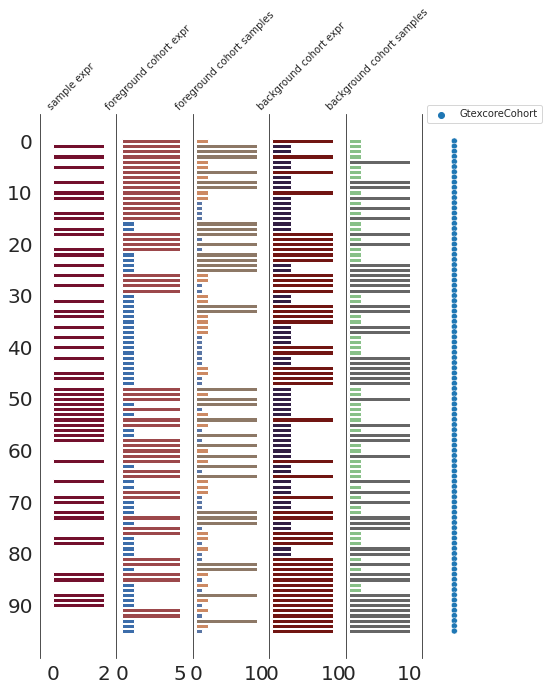

In [56]:
save = False
name_legend =  name_plot.split('png')[-2] + 'legend.png'
save_path = os.path.join(plot_dir, name_legend)
print(save_path)
foo = plot_legend(y1, y2, y3, y4, y5, y6, x, save_path, save)

In [60]:
foo[1].get_xticks()

array([-5.,  0.,  5.])